# Learning Routine

In [1]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time

style.use("ggplot")

SIZE = 10

HM_EPISODES = 25000
MOVE_PENALTY = 1
ENEMY_PENALTY = 300
FOOD_REWARD = 25
epsilon = 0.9
EPS_DECAY = 0.9998  # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 3000  # how often to play through env visually.

start_q_table = '/home/gokul/Documents/Studies/qtable-1586613516.pickle' # None or Filename

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1  # player key in dict
FOOD_N = 2  # food key in dict
ENEMY_N = 3  # enemy key in dict

# the dict!
d = {1: (255, 175, 0),
     2: (0, 255, 0),
     3: (0, 0, 255)}


class Blob:
    def __init__(self):
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)

    def __str__(self):
        return f"{self.x}, {self.y}"

    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)

    def action(self, choice):
        '''
        Gives us 4 total movement options. (0,1,2,3)
        '''
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)

    def move(self, x=False, y=False):

        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y


        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1


if start_q_table is None:
    # initialize the q-table#
    q_table = {}
    for i in range(-SIZE+1, SIZE):
        for ii in range(-SIZE+1, SIZE):
            for iii in range(-SIZE+1, SIZE):
                    for iiii in range(-SIZE+1, SIZE):
                        q_table[((i, ii), (iii, iiii))] = [np.random.uniform(-5, 0) for i in range(4)]

else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)


# can look up from Q-table with: print(q_table[((-9, -2), (3, 9))]) for example

episode_rewards = []

for episode in range(HM_EPISODES):

    # create character objects to participate in the space. Thier movements and positions are handled using 
    # the methods and attributes of the class. 
    player = Blob()
    food = Blob()
    enemy = Blob()
    
    ## show status for every 'SHOW_EVERY' episodes
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}, epsilon is {epsilon}")
        print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False
    ##
    
    episode_reward = 0
    
    for i in range(200):
        obs = (player-food, player-enemy) # currently observed states of food and enemy with respect to the player
        #print(obs)
        
        ## Choosing action based on the epsilon decaying random-exploratory settings ##
        if np.random.random() > epsilon:
            # GET THE ACTION
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 4)
        ##-------------------------------------------------------------------------
        
        ## Action Block - Perform the action! ##
        # LEVEL-1 - Static food and enemy #
        player.action(action)

        # LEVEL-2 - Random moving enemy and food #
        enemy.move()
        food.move()
        ##-------------------------------------------------------------------------        
        
        ## Reward assignment case- condition Block. ##
        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY
        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        else:
            reward = -MOVE_PENALTY
        ##-------------------------------------------------------------------------
            

        ## new Q value calculation and updating of Q table ##
        new_obs = (player-food, player-enemy) # new observed states based on newly performed action
        max_future_q = np.max(q_table[new_obs]) # max Q value for this new obs
        current_q = q_table[obs][action] # current Q for our chosen action
        
        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[obs][action] = new_q
        ##-------------------------------------------------------------------------
        
        ## display the environment ##
        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
            env[food.x][food.y] = d[FOOD_N]  # sets the food location tile to green color
            env[player.x][player.y] = d[PLAYER_N]  # sets the player tile to blue
            env[enemy.x][enemy.y] = d[ENEMY_N]  # sets the enemy location to red
            img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
            img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
            cv2.imshow("image", np.array(img))  # show it!
            
             #Breaks the display and the episode block if player reaches food
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:  # crummy code to hang at the end if we reach abrupt end for good reasons or not.
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        ##-------------------------------------------------------------------------

        episode_reward += reward # cumulative reward score obtained.

        # Breaks the display and the episode block if player reaches food or enemy (re- calling this outside the show block)
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            break

    #print(episode_reward)
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

        
print("----------------------------End of Routine-------------------")

on #0, epsilon is 0.9
3000 ep mean: nan


/home/gokul/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/gokul/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on #3000, epsilon is 0.49390083359356435
3000 ep mean: -130.42266666666666
on #6000, epsilon is 0.27104225936046566
3000 ep mean: -65.07466666666667
on #9000, epsilon is 0.14874221981913022
3000 ep mean: -31.482
on #12000, epsilon is 0.08162656262136181
3000 ep mean: -19.038
on #15000, epsilon is 0.044794919246742226
3000 ep mean: -15.504
on #18000, epsilon is 0.024582497729691496
3000 ep mean: -10.532
on #21000, epsilon is 0.01349035124500733
3000 ep mean: -7.788
on #24000, epsilon is 0.0074032174726434705
3000 ep mean: -7.679333333333333
----------------------------End of Routine-------------------


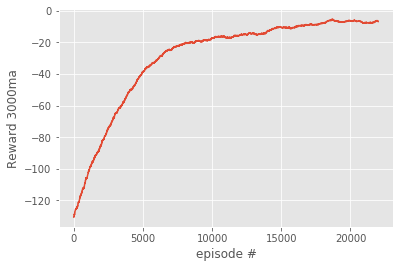

In [2]:
## Plot the Reward growth 
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()


In [3]:
with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)